# Adjacency complex filtration

In [76]:
import glob
import os
import json
import tifffile as tf
import numpy as np
import pandas as pd
import networkx as nx
from scipy import ndimage, stats, spatial

import matplotlib.pyplot as plt
import gudhi as gd

# JSON by construction does not recognize numerical keys; only string keys
def json_keys_to_int(json_dict):
    return {int(k): v for k, v in json_dict.items()}

# Get all the triangles from a networkx G 
def all_triangles(G):
    node_to_id = {node: i for i, node in enumerate(G)}
    for u in G:
        u_id = node_to_id[u]
        u_nbrs = G._adj[u].keys()
        for v in u_nbrs:
            v_id = node_to_id.get(v, -1)
            if v_id <= u_id:
                continue
            v_nbrs = G._adj[v].keys()
            for w in v_nbrs & u_nbrs:
                if node_to_id.get(w, -1) > v_id:
                    yield u, v, w

import matplotlib as mpl

wong = ['#000000','#f7bc38', '#41af91', '#0000ff', '#ff0000']
wong = ['#e69f00','#56b4e9','#009e73','#f0e442','#909090', '#0072b2','#d55e00','#cc79a7', '#cccccc']

In [2]:
filesrcs = sorted(glob.glob(os.pardir + os.sep + 'data' + os.sep + '*' + os.sep))
filesrcs

['../data/leaf_25d_WT2/',
 '../data/leaf_25d_WT4/',
 '../data/leaf_25d_WT4_random/',
 '../data/sepal/',
 '../data/sepal_random/']

In [3]:
sidx = 1

src = filesrcs[sidx]
dst = os.pardir + os.sep + 'results' + os.sep + os.path.dirname(src).split(os.sep)[-1] + os.sep
print(dst)

../results/leaf_25d_WT4/


In [33]:
tifffiles = sorted(glob.glob(src + '*.tif*'))
print(tifffiles)

tidx = 0
img = tf.imread(tifffiles[tidx])
css = ndimage.find_objects(img)
bname, _ = os.path.splitext(os.path.split(tifffiles[tidx])[1])
print(tidx, bname, sep='\t')

['../data/leaf_25d_WT4/segmentation.tiff']
0	segmentation


In [77]:
datafile = src + bname + '_metadata.csv'
print(datafile)
data = pd.read_csv(datafile).set_index('Label')

foo = ['#f0f0f0'] + np.tile(wong, len(data)+2).tolist()
cmap = mpl.colors.ListedColormap(foo[:len(data)+1])
gpos = dict(zip(range(1,len(data)+1), data[['centerX', 'centerY']].to_numpy())) 

print(data.shape)
data.head()

../data/leaf_25d_WT4/segmentation_metadata.csv
(638, 8)


,centerX,centerY,perimeter,area,ch_perimeter,ch_area,pconvexity,aconvexity
Label,,,,,,,,
1,61.373869,58.106198,580.546248,11940,470.552743,15041.0,0.810534,0.793830
2,18.980871,142.452079,408.048773,5123,366.442229,6587.5,0.898035,0.777685
3,232.277407,211.739969,2325.228714,50817,1257.422040,104085.0,0.540773,0.488226
4,26.463696,290.688065,260.894444,3209,236.955745,3862.5,0.908244,0.830809
5,250.284159,411.948938,2834.414572,64960,1388.076410,122924.5,0.489722,0.528454


In [88]:
lens = data['area']
mimg = img.copy().astype(float)
for idx in data.index:
    mimg[css[idx - 1]][ mimg[css[idx-1]] == idx ] = lens.loc[idx]

In [7]:
datafile = src + bname + '_neighbors.json'
print(datafile)

with open(datafile, "r") as f:
    neighbors = json.load(f, object_hook=json_keys_to_int)
print(len(neighbors))
neighbors[1]

../data/leaf_25d_WT4/segmentation_neighbors.json
638


[2, 44, 45, 48, 50, 56]

In [21]:
g = nx.Graph()
g.add_nodes_from(range(1,1+len(data)))
for node in g.nodes():
    edges = [ [node, vertex] for vertex in neighbors[node]]
    g.add_edges_from(edges)

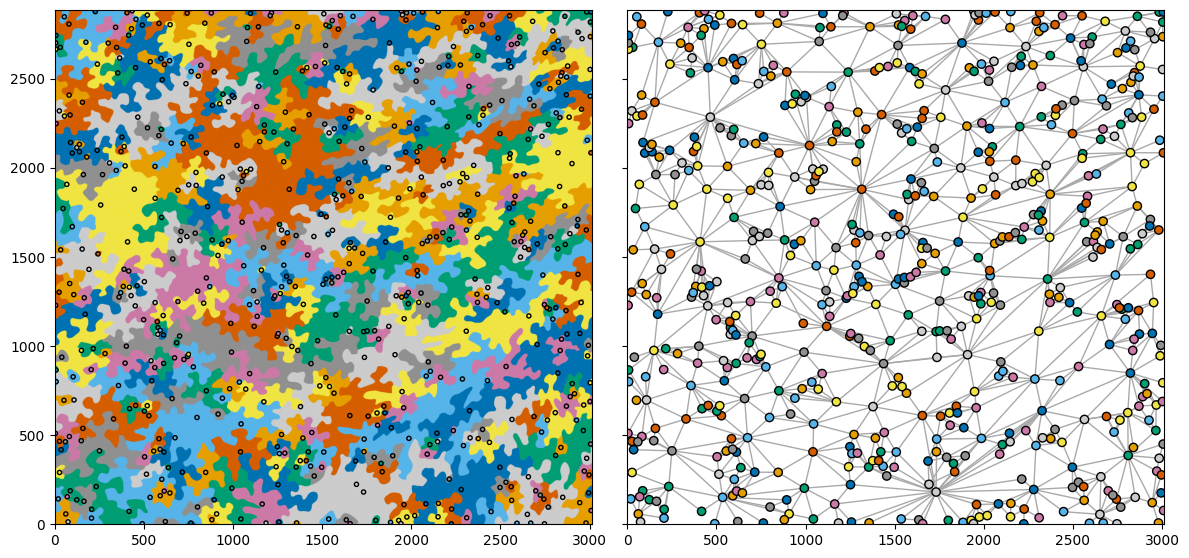

In [78]:
#drawkw = dict(G=Gcpy, node_size=0, width = 0.75*np.cbrt(width), 
#              edge_color=width, edge_cmap=mpl.colormaps['Greys'], edge_vmin=-7, edge_vmax=7,
#              with_labels=False, hide_ticks=True, font_size=6)

fig, ax = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True); 
ax = np.atleast_1d(ax).ravel()
i = 0
ax[i].imshow(img, origin='lower', cmap=cmap, vmin=0)
ax[i].scatter(data['centerX'], data['centerY'], marker='.', ec='k', c=data.index, cmap=cmap, vmin=0)
i = 1
nx.draw_networkx(g, pos=gpos, ax=ax[i], with_labels=False, node_size=0, edge_color='darkgray', hide_ticks=False)
ax[i].scatter(data['centerX'], data['centerY'], c=data.index, cmap=cmap, vmin=0, ec='k')
ax[i].set_aspect('equal')
ax[i].set_ylim(0, img.shape[0])
ax[i].set_xlim(0, img.shape[1])

fig.tight_layout();

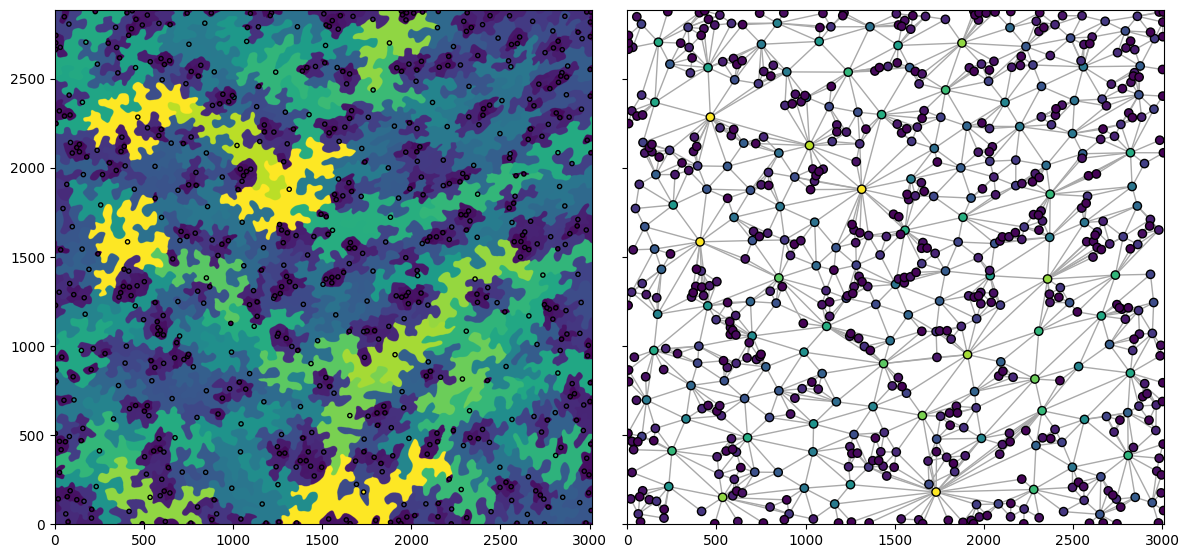

In [98]:
qq = np.quantile(lens, 0.995)
fig, ax = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True); 
ax = np.atleast_1d(ax).ravel()
i = 0
ax[i].imshow(mimg, origin='lower', cmap='viridis', vmin=0, vmax=qq)
ax[i].scatter(data['centerX'], data['centerY'], marker='.', ec='k', c=lens, cmap='viridis', vmin=0, vmax=qq)
i = 1
nx.draw_networkx(g, pos=gpos, ax=ax[i], with_labels=False, node_size=0, edge_color='darkgray', hide_ticks=False)
ax[i].scatter(data['centerX'], data['centerY'], c=lens, cmap='viridis', vmin=0, ec='k', vmax=qq)
ax[i].set_aspect('equal')
ax[i].set_ylim(0, img.shape[0])
ax[i].set_xlim(0, img.shape[1])

fig.tight_layout();

In [113]:
st = gd.SimplexTree()
for idx in data.index:
    st.insert([idx], lens.loc[idx])
for edge in g.edges():
    st.insert(edge, max( [lens.loc[edge[0]], lens.loc[edge[1]]] ) )
for tri in all_triangles(g):
    st.insert(tri, max( [ lens.loc[tri[0]], lens.loc[tri[1]], lens.loc[tri[2]] ] ) )
st_gen = st.get_filtration() 
for splx in st_gen :
    print(splx)

([95], 111.0)
([474], 113.0)
([576], 131.0)
([638], 181.0)
([32], 184.0)
([8], 189.0)
([637], 199.0)
([31], 203.0)
([107], 220.0)
([119], 227.0)
([636], 240.0)
([273], 242.0)
([597], 247.0)
([413], 253.0)
([33], 263.0)
([223], 366.0)
([405], 367.0)
([398], 384.0)
([325], 399.0)
([183], 401.0)
([359], 410.0)
([560], 410.0)
([583], 420.0)
([322], 425.0)
([26], 451.0)
([542], 457.0)
([17], 525.0)
([617], 532.0)
([634], 543.0)
([635], 547.0)
([461], 570.0)
([556], 612.0)
([505], 619.0)
([630], 629.0)
([12], 638.0)
([252], 644.0)
([184], 645.0)
([183, 184], 645.0)
([551], 646.0)
([64], 669.0)
([142], 672.0)
([200], 674.0)
([44], 679.0)
([146], 687.0)
([186], 699.0)
([285], 706.0)
([289], 719.0)
([390], 720.0)
([632], 726.0)
([539], 733.0)
([539, 551], 733.0)
([618], 737.0)
([328], 740.0)
([69], 744.0)
([120], 747.0)
([92], 749.0)
([330], 750.0)
([41], 752.0)
([365], 752.0)
([596], 752.0)
([213], 758.0)
([54], 769.0)
([350], 770.0)
([45], 772.0)
([611], 774.0)
([70], 783.0)
([489], 788.0)
([

In [167]:
pers = st.persistence(homology_coeff_field=2, min_persistence=0, persistence_dim_max=False)
df = pd.DataFrame(index=range(len(pers)), columns = ['k','b','d', 'lt'])
for i in range(len(pers)):
    k, (b,d) = pers[i]
    df.iloc[i, :] = [k, b, d, d-b]
#df = df[ df['d'] < np.inf].astype(int)
mx = df.loc[ df['d'] < np.inf, ['b','d'] ].max(None)
df.head()

,k,b,d,lt
0,1,60446.0,129908.0,69462.0
1,1,60734.0,100144.0,39410.0
2,1,87853.0,100700.0,12847.0
3,1,65239.0,75844.0,10605.0
4,1,78225.0,84588.0,6363.0


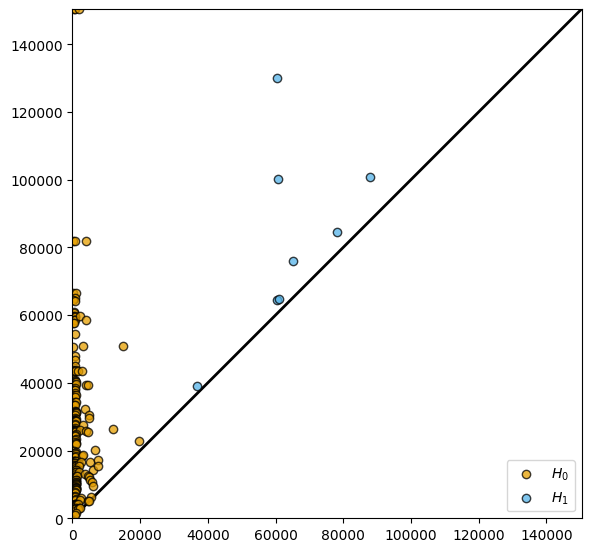

In [169]:
fig, ax = plt.subplots(1,1, figsize=(6,6), sharex=True, sharey=True); 
ax = np.atleast_1d(ax).ravel(); i = 0
ax[i].set_xlim(0,mx)
ax[i].set_ylim(0,mx)
ax[i].axline((0,0), slope=1, c='k', lw=2, zorder=1)
for k in [0,1]:
    foo = df[df['k'] == k]
    ax[i].scatter(foo['b'], foo['d'], c=wong[k], ec='k', label='$H_{{{}}}$'.format(k), alpha=0.75, zorder=k+2)
ax[i].legend(loc='lower right')
ax[i].set_aspect('equal')
fig.tight_layout();

In [174]:
ls_gens = st.lower_star_persistence_generators()

print(lens.min())
for feature in ls_gens[1]:
    print(feature, st.filtration(feature), sep='\t')
df[ df['d'] == np.inf]

111
[95]	111.0


,k,b,d,lt
8,0,111.0,inf,inf


In [180]:
for (b,d) in ls_gens[0][1]:
    print((b,d), st.filtration([b]), st.filtration([d]), st.filtration([d]) - st.filtration([b]), sep='\t')

(491, 504)	36921.0	38925.0	2004.0
(277, 228)	60446.0	64473.0	4027.0
(288, 442)	60969.0	64697.0	3728.0
(438, 434)	65239.0	75844.0	10605.0
(313, 351)	78225.0	84588.0	6363.0
(196, 67)	60734.0	100144.0	39410.0
(160, 63)	87853.0	100700.0	12847.0
(277, 214)	60446.0	129908.0	69462.0


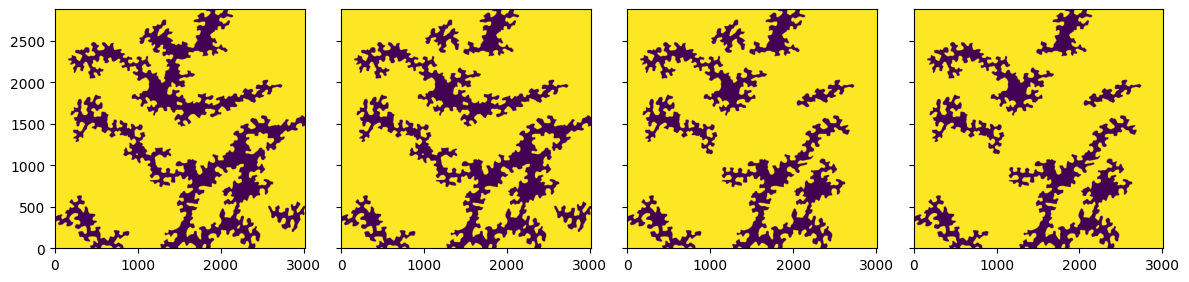

In [199]:
b,d = 60734.0 , 100144.0
b,d = 60446.0 , 64473.0	

fig, ax = plt.subplots(1,4, figsize=(12,5), sharex=True, sharey=True); 
ax = np.atleast_1d(ax).ravel()
i = 0
ax[i].imshow(mimg < b-1, origin='lower', cmap='viridis', vmin=0, vmax=1)
i += 1
ax[i].imshow(mimg <= b, origin='lower', cmap='viridis', vmin=0, vmax=1)
i += 1
ax[i].imshow(mimg < d-1, origin='lower', cmap='viridis', vmin=0, vmax=1)
i += 1
ax[i].imshow(mimg <= d, origin='lower', cmap='viridis', vmin=0, vmax=1)

fig.tight_layout();

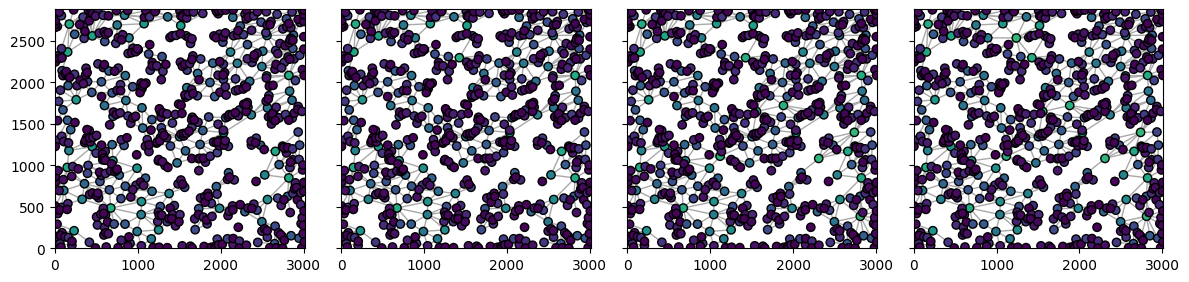

In [202]:
fig, ax = plt.subplots(1,4, figsize=(12,4.5), sharex=True, sharey=True); 
ax = np.atleast_1d(ax).ravel()
for i in range(len(ax)):
    ax[i].set_ylim(0, img.shape[0])
    ax[i].set_xlim(0, img.shape[1])
    #ax[i].axis('off')
    ax[i].set_aspect('equal')

i = 0
idx = lens[lens < b-1].index
subg = g.subgraph(idx)
subpos = {k:gpos[k] for k in idx}
nx.draw_networkx(subg, pos=subpos, ax=ax[i], with_labels=False, node_size=0, edge_color='darkgray', hide_ticks=False)
ax[i].scatter(data.loc[idx, 'centerX'], data.loc[idx, 'centerY'], c=lens.loc[idx], cmap='viridis', vmin=0, ec='k', vmax=qq)

i += 1
idx = lens[lens <= b].index
subg = g.subgraph(idx)
subpos = {k:gpos[k] for k in idx}
nx.draw_networkx(subg, pos=subpos, ax=ax[i], with_labels=False, node_size=0, edge_color='darkgray', hide_ticks=False)
ax[i].scatter(data.loc[idx, 'centerX'], data.loc[idx, 'centerY'], c=lens.loc[idx], cmap='viridis', vmin=0, ec='k', vmax=qq)

i += 1
idx = lens[lens < d-1].index
subg = g.subgraph(idx)
subpos = {k:gpos[k] for k in idx}
nx.draw_networkx(subg, pos=subpos, ax=ax[i], with_labels=False, node_size=0, edge_color='darkgray', hide_ticks=False)
ax[i].scatter(data.loc[idx, 'centerX'], data.loc[idx, 'centerY'], c=lens.loc[idx], cmap='viridis', vmin=0, ec='k', vmax=qq)

i += 1
idx = lens[lens <= d].index
subg = g.subgraph(idx)
subpos = {k:gpos[k] for k in idx}
nx.draw_networkx(subg, pos=subpos, ax=ax[i], with_labels=False, node_size=0, edge_color='darkgray', hide_ticks=False)
ax[i].scatter(data.loc[idx, 'centerX'], data.loc[idx, 'centerY'], c=lens.loc[idx], cmap='viridis', vmin=0, ec='k', vmax=qq)

fig.tight_layout();

In [ ]:
i